
# Fake news classification
Dataset https://www.kaggle.com/c/fake-news/data

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('dataset/train.csv', index_col=['id'])
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Предобработка и анализ

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   text    20761 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 812.5+ KB


In [4]:
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

In [6]:
df.drop(['title', 'author'], axis=1, inplace=True)

In [7]:
df['label'].value_counts()

0    10361
1     7924
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x1ffb67c0850>,
 [Text(-0.22861036734329143, 1.0759820165519336, 'True'),
  Text(0.2286102666025835, -1.0759820379559761, 'False')])

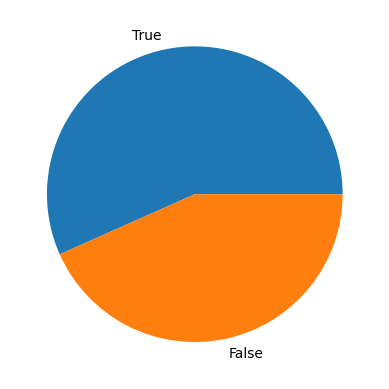

In [8]:
n_true = df.shape[0]-df['label'].sum()
n_false = df['label'].sum()
plt.pie([n_true, n_false], labels=['True', 'False'])

Уберем стоп-слова и проведем лемматизацию

In [9]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

df['cleaned_text'] = df['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if 
        not token.is_stop 
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)

In [10]:
df.head()

,text,label,cleaned_text
id,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide comey letter jason chaffetz twe...
1,Ever get the feeling your life circles the rou...,0,feeling life circle roundabout head straight l...
2,"Why the Truth Might Get You Fired October 29, ...",1,truth fire october tension intelligence analys...
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians kill single airstrike identif...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentence year prison iran ...


Определим частоту встречаемых слов

In [11]:
def get_top_ngrams(corpus, ngram_range, stop_words=None, n=None):
    vec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key=lambda x: x[1], reverse=True)
    
    common_words = words_freq[:n]
    words = []
    freqs = []
    for word, freq in common_words:
        words.append(word)
        freqs.append(freq)
        
    df = pd.DataFrame({'Word': words, 'Freq': freqs})
    return df

In [14]:
stop_words = 'english'
n = 20
unigrams_st = get_top_ngrams(df['cleaned_text'], (1, 1), stop_words, n)
bigrams_st = get_top_ngrams(df['cleaned_text'], (2, 2), stop_words, n)
trigrams_st = get_top_ngrams(df['cleaned_text'], (3, 3), stop_words, n)

<BarContainer object of 20 artists>

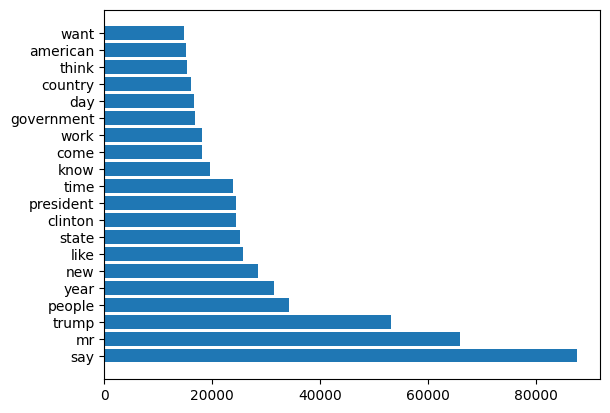

In [15]:
plt.barh(unigrams_st['Word'], unigrams_st['Freq'], )

<BarContainer object of 20 artists>

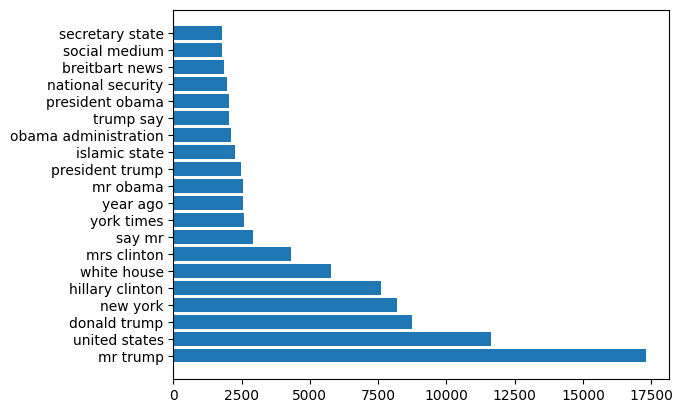

In [16]:
plt.barh(bigrams_st['Word'], bigrams_st['Freq'], )

<BarContainer object of 20 artists>

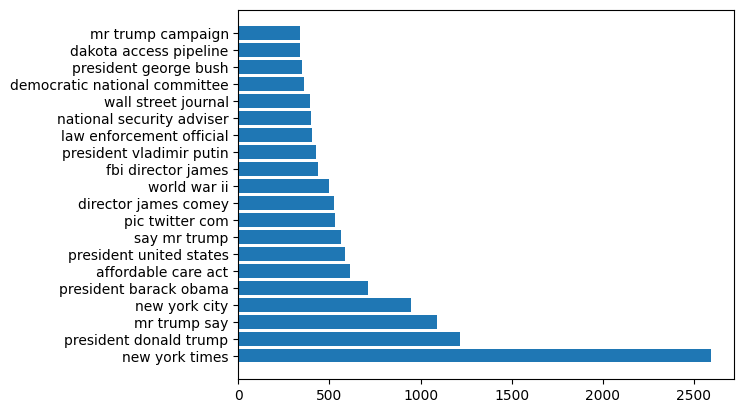

In [17]:
plt.barh(trigrams_st['Word'], trigrams_st['Freq'], )

Проведем векторизацию с помощью TF-IDF

In [18]:
X_data = df['cleaned_text']

In [19]:
y = df['label']

In [20]:
vect = TfidfVectorizer(use_idf=True)
X_tfid = vect.fit_transform(X_data)

In [21]:
X_tfid.shape

(18285, 145295)

Используем SVD для понижения размерности

In [22]:
svd = TruncatedSVD(n_components=256, n_iter=25, random_state=2023)

In [23]:
X_svd = svd.fit_transform(X_tfid)

In [24]:
X_svd.shape

(18285, 256)

## Baseline
Для задачи бинарной классификации со сбалансированными классами в качестве метики выберем accuracy

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13713, 256), (13713,), (4572, 256), (4572,))

### Случайный лес

In [26]:
param_grid = {'min_samples_split': (2, 4, 8),
              'min_samples_leaf': (1, 4),
              'n_estimators': (100, 200),
              'max_depth': ( 2, 4)}

rf_clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=StratifiedKFold(5), n_jobs=7)
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=7,
             param_grid={'max_depth': (2, 4), 'min_samples_leaf': (1, 4),
                         'min_samples_split': (2, 4, 8),
                         'n_estimators': (100, 200)})

In [27]:
rf_clf.best_params_

{'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 200}

In [31]:
predictions = rf_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.847769028871391